
##  Exploratory Data Analysis 

In [119]:

import pandas as pd
# from pandas_profiling import ProfileReport

# pwd: esun_sar_baseline
CCBA_PATH = 'train_first/public_train_x_ccba_full_hashed.csv'
CDTX_PATH = 'train_first/public_train_x_cdtx0001_full_hashed.csv'
CUSTINFO_PATH = 'train_first/public_train_x_custinfo_full_hashed.csv'
DP_PATH = 'train_first/public_train_x_dp_full_hashed.csv'
REMIT_PATH = 'train_first/public_train_x_remit_full_hashed.csv'
PDATE_PATH = 'train_first/public_x_alert_date.csv'
TDATE_PATH = 'train_first/train_x_alert_date.csv'
ANSWER_PATH = 'train_first/train_y_answer.csv'
SAMPLE_PATH = './sample_submission.csv'
PUBANSWER_PATH = './train_first/24_ESun_public_y_answer.csv'

ccba = pd.read_csv(CCBA_PATH)
cdtx = pd.read_csv(CDTX_PATH)
cinfo = pd.read_csv(CUSTINFO_PATH)
dp = pd.read_csv(DP_PATH)
remit = pd.read_csv(REMIT_PATH)
pdate = pd.read_csv(PDATE_PATH)

tdate = pd.read_csv(TDATE_PATH)
answer = pd.read_csv(ANSWER_PATH)
sample = pd.read_csv(SAMPLE_PATH)

pubans = pd.read_csv(PUBANSWER_PATH) 


In [120]:
ccba.head()

,cust_id,lupay,byymm,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,0,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,30,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,61,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,91,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,122,152628.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
mostarts = ccba.byymm.value_counts().keys().tolist()
mostarts.sort()
mostarts

[0, 30, 61, 91, 122, 153, 183, 214, 244, 275, 306, 334, 365]

In [122]:
class RangeDict(dict):
    def __getitem__(self, item):
        if not isinstance(item, range): # or xrange in Python 2
            for key in self:
                if item in key:
                    return self[key]
            raise KeyError(item)
        else:
            return super().__getitem__(item) # or super(RangeDict, self) for Python 2

# stealth_check = RangeDict({range(1,6): 'thunderstorm', range(6,11): 'tip-toe'})
# stealth_roll = 8
# print(stealth_check[stealth_roll]) # prints 'tip-toe'
# reference: https://stackoverflow.com/questions/39358092/range-as-dictionary-key-in-python 
month_aggregator = RangeDict() 
for i in range(len(mostarts)-1):
    print(i, (mostarts[i], mostarts[i+1]))
    if i == len(mostarts)-2:
        month_aggregator[range(mostarts[i], mostarts[i+1]+1)] = i+1
    else:
        month_aggregator[range(mostarts[i], mostarts[i+1])] = i+1 # month
month_aggregator[range(366, 400)] = 13
month_aggregator

0 (0, 30)
1 (30, 61)
2 (61, 91)
3 (91, 122)
4 (122, 153)
5 (153, 183)
6 (183, 214)
7 (214, 244)
8 (244, 275)
9 (275, 306)
10 (306, 334)
11 (334, 365)


{range(0, 30): 1,
 range(30, 61): 2,
 range(61, 91): 3,
 range(91, 122): 4,
 range(122, 153): 5,
 range(153, 183): 6,
 range(183, 214): 7,
 range(214, 244): 8,
 range(244, 275): 9,
 range(275, 306): 10,
 range(306, 334): 11,
 range(334, 366): 12,
 range(366, 400): 13}

In [123]:
month_aggregator[200]

7

In [124]:
# merging 
date = pd.concat([pdate, tdate], axis=0)
cinfo = cinfo.merge(date, on='alert_key', how='left')
cinfo = cinfo.merge(answer, on='alert_key', how='left')
# public answer
cinfo = cinfo.merge(pubans, on='alert_key', how='left')   

In [131]:
cinfo.head
cinfo['sar_flag_x'] = cinfo['sar_flag_x'].fillna(0)
cinfo['sar_flag_y'] = cinfo['sar_flag_y'].fillna(0)
cinfo['sar_flag'] = cinfo['sar_flag_x'] + cinfo['sar_flag_y']
cinfo['sar_flag'].value_counts(dropna = False)

0.0    25506
1.0      245
Name: sar_flag, dtype: int64

In [132]:
cinfo['sar_flag_x'].value_counts(dropna = False)

0.0    25517
1.0      234
Name: sar_flag_x, dtype: int64

In [ ]:

import pickle

from sklearn.preprocessing import QuantileTransformer
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
from tqdm import tqdm


from process_data.data_config import (DataSource, FeatureType,
                         CCBAConfig, CDTXConfig, DPConfig, REMITConfig, CUSTINFOConfig,
                         CONFIG_MAP)
from process_data.utils import load_yaml, save_yaml, save_pickle, load_pickle
datas = [
    (ccba, DataSource.CCBA), 
    (cdtx, DataSource.CDTX),
    (dp, DataSource.DP),
    (remit, DataSource.REMIT),
    (cinfo, DataSource.CUSTINFO),
]

num_cat_dict = {}
def get_date(d):
    ds = d.data_source.iloc[0]
    if ds == DataSource.CCBA:
        date = "byymm" 
    elif ds == DataSource.CDTX:
        date = "date"
    elif ds == DataSource.DP:
        date = "tx_date"
    elif ds == DataSource.REMIT:
        date = "trans_date"
    elif ds == DataSource.CUSTINFO:
        date =  "date"
    return date 
data_source_map = {
    DataSource.CCBA: 'ccba',
    DataSource.CDTX: 'cdtx',
    DataSource.DP: 'dp',
    DataSource.REMIT: 'remit',
    DataSource.CUSTINFO: 'cinfo',
}
# process numerical and categorical and data_source
monthly = {} 
for data, data_source in datas:
    print(data_source)
    data['data_source'] = data_source
    config = CONFIG_MAP[data_source]  
    datecol = get_date(data)
    data['month'] = data[datecol].apply(lambda x: month_aggregator[x])
    
    tablename = data_source_map[data_source]
    monthly[tablename] = data.groupby(['month']).size().to_dict()
from pprint import pprint
# pprint(monthly)


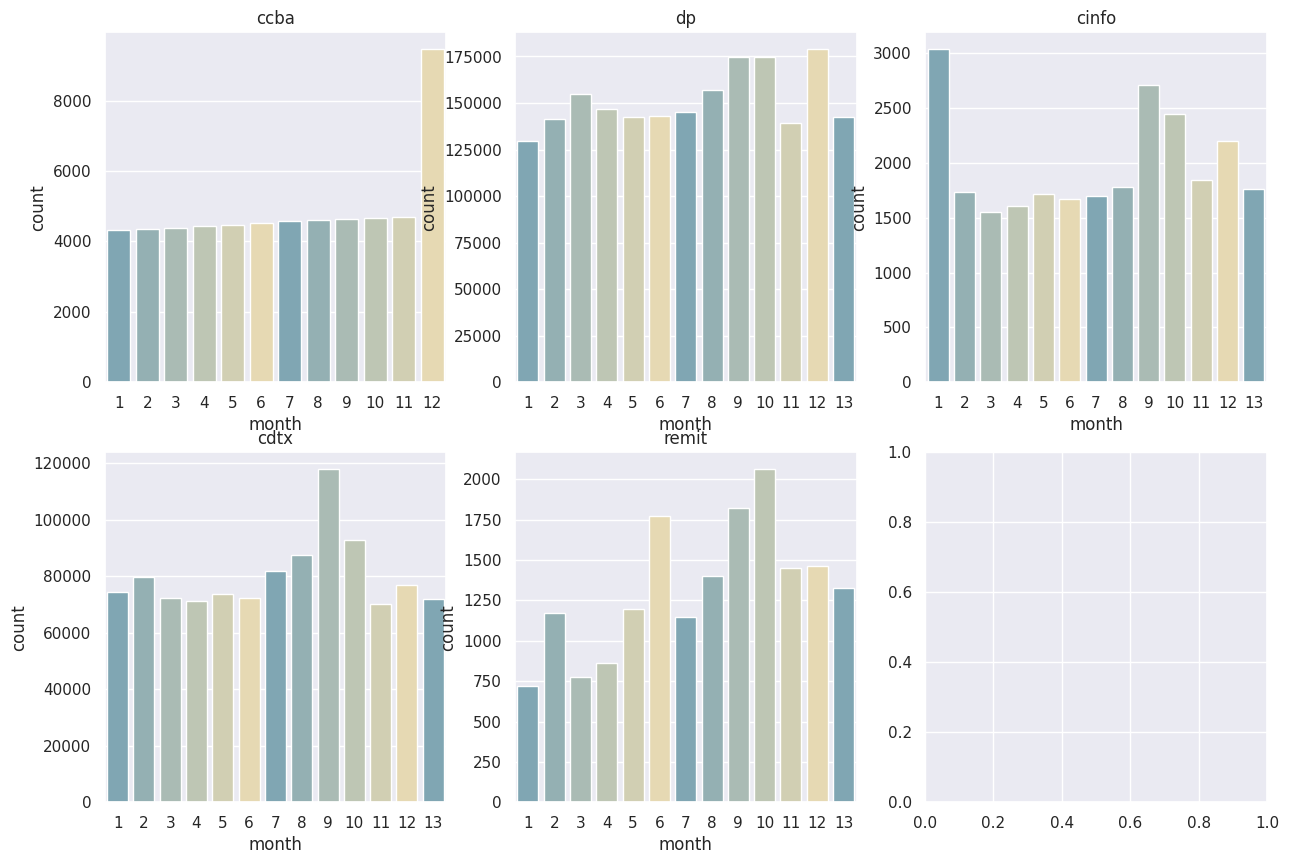

In [134]:
# group by cust_id, and then by month  
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette = 'muted')
fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
for i, (data, ds) in enumerate(datas):
    datag = data.groupby(['cust_id', 'month']).size()
    ax = sns.countplot(x=data['month'], palette = sns.color_palette("blend:#7AB,#EDA"), ax = axs[i%2][i//2])
    ax.set_title(data_source_map[ds])

## Loading customer embeddings 
dense embeddings geenrated from Deberta 

In [135]:
# identify the sar customers 
sars = cinfo[cinfo.sar_flag == 1] 
scusts = sars.cust_id.unique()

In [166]:
from pprint import pprint 
import os
import pickle
embeddir = '/home/nanaeilish/projects/Github/esun_sar_baseline/src/save_embeds'
epoch = 10 # fold 4, epoch 10 has valid recall at 0.02
# Train Epoch: 10 Loss: 0.668436: 100%|████████████████████████████████████████████████████████████████| 299/299 [03:49<00:00,  1.31it/s]
#     epoch          : 10
#     loss           : 1.5205923188290866
#     recall_n       : 0.010493938845666727
#     val_loss       : 2.2209672421216964
#     val_recall_n   : 0.020833333333333332
epochdir= f'{embeddir}/epoch{epoch}'
custembeds = {}
for filename in os.listdir(epochdir): 
    # print(f'loading {filename}') 
    if filename.endswith('.pkl'):
        with open(os.path.join(epochdir, filename), 'rb') as f:
            batch_embed = pickle.load(f)
        custembeds.update(batch_embed) 
print(f'total customer embed count {len(custembeds)}')   


total customer embed count 6160


In [167]:

# t-sne 
import numpy as np 
from sklearn.manifold import TSNE as tsne 

custembs = sorted(custembeds.items(), key = lambda x:x[0])
custids, custembs = zip(*custembs) 
embed_array = np.stack(custembs, axis=0)
embed_array.astype(np.float32)
print(embed_array.shape)

X_reduced  = tsne(n_components = 2, 
                init = 'pca', n_iter = 1000,  
                 random_state = 42).fit_transform(embed_array)
print(X_reduced.shape)


(6160, 256)
(6160, 2)


## Do t-SNE

[]

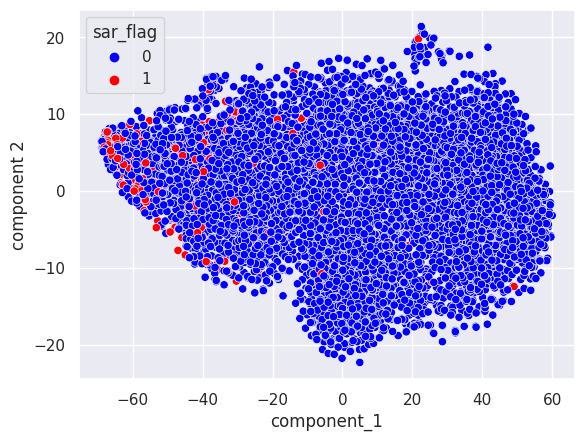

In [169]:

import matplotlib.pyplot as plt 
# need to concat the reduced data with the sar flag 
df = pd.DataFrame(X_reduced, columns = ['component_1', 'component 2'])
# plt.ylim((-30, 30))
# plt.xlim((-50, 40))
df['cust_id'] = custids
df['sar_flag'] = df['cust_id'].apply(lambda x: 1 if x in scusts else 0)
sns.scatterplot(data = df, x = 'component_1', y = 'component 2', hue = 'sar_flag', palette={0: "blue", 1: "red"}).plot()

In [ ]:
# wow looks good 